# Brain MRI Classification using CNN  

## Introduction  
Brain tumors are a critical medical condition that can significantly impact a person's health. Early detection and accurate classification of brain tumors are essential for timely treatment and better patient outcomes. Magnetic Resonance Imaging (MRI) is a widely used technique for brain tumor detection due to its high-resolution imaging capabilities.  

In this project, we have developed a Convolutional Neural Network (CNN) model to classify brain MRI images into four categories:  
- **Healthy** (No tumor)  
- **Meningioma**  
- **Pituitary Tumor**  
- **Glioma**  

The images were preprocessed using the PIL (Pillow) library, resizing them to `(200, 200, 3)`. We used **ImageDataGenerator** for data augmentation to improve model generalization. The model was trained and validated using a structured dataset, achieving an accuracy of **92%**, demonstrating its effectiveness in tumor classification.  


### Imprort Libraries:

In [1]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, ZeroPadding2D, ReLU 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fetch datasets
file_path = r'/kaggle/input/brain-tumor-mri-scans'

In [3]:
def retrieve_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.gif')):
            filepath = os.path.join(directory, filename)
            try:
                img = Image.open(filepath)
                img = img.resize((200, 200), Image.LANCZOS)
                img = img.convert('RGB')
                img = np.asarray(img) / 255.0
                images.append(img)
            except IOError:
                print(f"The file opening error: {filepath}")
    return images

pituitary = retrieve_images(file_path + '/pituitary')
healthy = retrieve_images(file_path + '/healthy')
meningioma = retrieve_images(file_path + '/meningioma')
glioma = retrieve_images(file_path + '/glioma')

In [4]:
# Creatig the Data Frame with image and class
# Classes: healthy : 0, pituitary : 1, meningiona : 2, glioma : 3
healthy_df = pd.DataFrame({
    'image' : healthy,
    'class' : np.full(len(healthy), 0)
})
pituitary_df = pd.DataFrame({
    'image' : pituitary,
    'class' : np.full(len(pituitary), 1)
})
meningiona_df = pd.DataFrame({
    'image' : meningioma,
    'class' : np.full(len(meningioma), 2)
})
glioma_df = pd.DataFrame({
    'image' : glioma,
    'class' : np.full(len(glioma), 3)
})

df = pd.concat([healthy_df, pituitary_df, meningiona_df, glioma_df], ignore_index = True)
df.head()

,image,class
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
2,"[[[0.0, 0.0, 0.0], [0.0196078431372549, 0.0196...",0
3,"[[[0.7098039215686275, 0.7098039215686275, 0.7...",0
4,"[[[0.4392156862745098, 0.4392156862745098, 0.4...",0


In [5]:
# Finding the null values.
df.isnull().sum()

image    0
class    0
dtype: int64

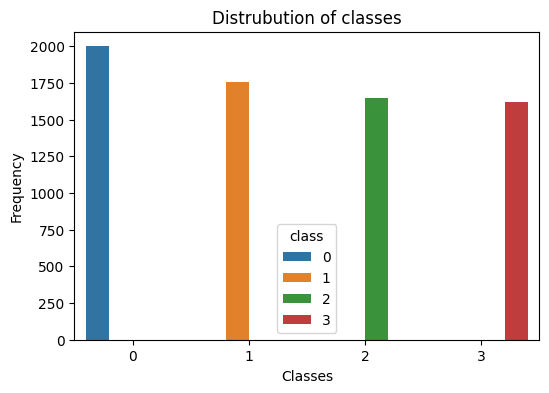

In [6]:
# Number of classes
plt.figure(figsize = (6,4))
sns.countplot(df, x = 'class', hue = 'class')
plt.title('Distrubution of classes')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

So our dataset contains four classes and also they are balanced class. The highest one of them is pituitary and lowest number of class is glioma.

### Spliting the data into sets:

In [7]:
train_image, valid_test_image, train_class, valid_test_class = train_test_split(df['image'], df['class'], test_size = 0.2, random_state = 42)
valid_image, test_image, valid_class, test_class = train_test_split(valid_test_image, valid_test_class, test_size = 0.05, random_state = 42)

print(f"Train Image: {train_image.shape}")
print(f"Train Class: {train_class.shape}")
print(f"Valid Image: {valid_image.shape}")
print(f"Valid Class: {valid_class.shape}")
print(f"Test Image: {test_image.shape}")
print(f"Test Class: {test_class.shape}")

Train Image: (5618,)
Train Class: (5618,)
Valid Image: (1334,)
Valid Class: (1334,)
Test Image: (71,)
Test Class: (71,)


Here we have problem that train and validation image arrays are not in right order like (num_samples, 200, 200, 3). So we have to fix it.

In [8]:
# Correcting the sets
train_image = np.stack(train_image)

valid_image = np.stack(valid_image)

test_image = np.stack(test_image)

print(f"Train Image: {train_image.shape}")
print(f"Train Class: {train_class.shape}")
print(f"Valid Image: {valid_image.shape}")
print(f"Valid Class: {valid_class.shape}")
print(f"Test Image: {test_image.shape}")
print(f"Test Class: {test_class.shape}")

Train Image: (5618, 200, 200, 3)
Train Class: (5618,)
Valid Image: (1334, 200, 200, 3)
Valid Class: (1334,)
Test Image: (71, 200, 200, 3)
Test Class: (71,)


### Employ Image Data Generator:

In [9]:
# Datagenerate for train image
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

train_gen = train_datagen.flow(x = train_image,
                               y = train_class,
                               batch_size = 32,
                              shuffle = True,
                              seed = 42)

# Validation Image Data Generator
valid_datagen = ImageDataGenerator(
    rescale=1.0/255,
)

valid_gen = valid_datagen.flow(
    x=valid_image,
    y = valid_class,
    batch_size=32,
    shuffle=False,  # No shuffling for validation data
    seed=42
)

# Test Image Data Generator
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
)

test_gen = test_datagen.flow(
    x=test_image,
    y = test_class,
    batch_size=32,
    shuffle=False,  # No shuffling for test data
    seed=42
)


### Using EfficientNetB0 architecture:

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, ReLU, BatchNormalization, MaxPooling2D, ZeroPadding2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

# Define Input
input_layer = Input(shape=(200, 200, 3))

# Convolutional Layer 1
x = Conv2D(128, (6, 6), strides=(4, 4), padding='valid')(input_layer)
x = ReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid')(x)

# Convolutional Layer 2
x = ZeroPadding2D(padding=(2, 2))(x)
x = Conv2D(96, (6, 6), strides=(1, 1), padding='valid')(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid')(x)

# Convolutional Layer 3
x = ZeroPadding2D(padding=(2, 2))(x)
x = Conv2D(96, (2, 2), strides=(1, 1), padding='valid')(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid')(x)

# Flatten Layer
x = Flatten()(x)

# Fully Connected Layer 1
x = Dense(512, activation='relu')(x)

# Dropout Layer
x = Dropout(0.3)(x)

# Fully Connected Layer 2 (Output)
output_layer = Dense(4, activation='softmax')(x)

# Create the Model
model = Model(inputs=input_layer, outputs=output_layer)

# Model Compilation
model.compile(
    optimizer = Adam(learning_rate = 1e-3),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

# Summary of Model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 49, 49, 128)         │          13,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 49, 49, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 49, 49, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 23, 23, 96)          │         442,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 23, 23, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 15, 15, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 96)          │          36,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4704)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,408,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,904,900 (11.08 MB)

 Trainable params: 2,904,644 (11.08 MB)

 Non-trainable params: 256 (1.00 KB)

In [11]:
# Defining the Call Backs
# early_stopping = EarlyStopping(
#     monitor = 'val_loss',
#     patience = 5,
#     verbose = 1,
#     restore_best_weights = True
# )
# model_check_point = ModelCheckpoint(
#     filepath = 'best_model.keras',
#     monitor = 'val_loss',
#     save_best_only = True,
#     verbose = 1
# )
# reduce_lr = ReduceLROnPlateau(
#     monitor = 'val_loss',
#     factor = 0.1,
#     patience = 3,
#     verbose = 1,
#     min_lr = 1e-6
# )

In [12]:
# Model Fit
train_per_epoch = int(len(train_image) // 32)  # Number of steps per epoch train
valid_per_epoch = int(len(valid_image) // 32) # Numeber of steps per epoch validation

history = model.fit(
    train_gen,
    steps_per_epoch = train_per_epoch,
    validation_data = valid_gen,
    validation_steps = valid_per_epoch,
    epochs=50
)

Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 51s 249ms/step - accuracy: 0.4712 - loss: 1.1598 - val_accuracy: 0.3765 - val_loss: 1.4301
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5938 - loss: 1.0520 - val_accuracy: 0.1818 - val_loss: 1.4671
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 43s 233ms/step - accuracy: 0.6315 - loss: 0.8960 - val_accuracy: 0.2401 - val_loss: 1.5884
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.7812 - loss: 0.6693 - val_accuracy: 0.1364 - val_loss: 1.7883
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - accuracy: 0.7058 - loss: 0.7326 - val_accuracy: 0.3064 - val_loss: 3.9757
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - accuracy: 0.7812 - loss: 0.5807 - val_accuracy: 0.2273 - val_loss: 4.4191
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - accuracy: 0.7643 - loss: 0.5813 - val_accuracy: 0.3102 - val_loss: 4.0909
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 114us/step - accuracy: 0.8125 - loss: 0.6319 - 

Text(0.5, 1.0, 'Accuracy over iteration')

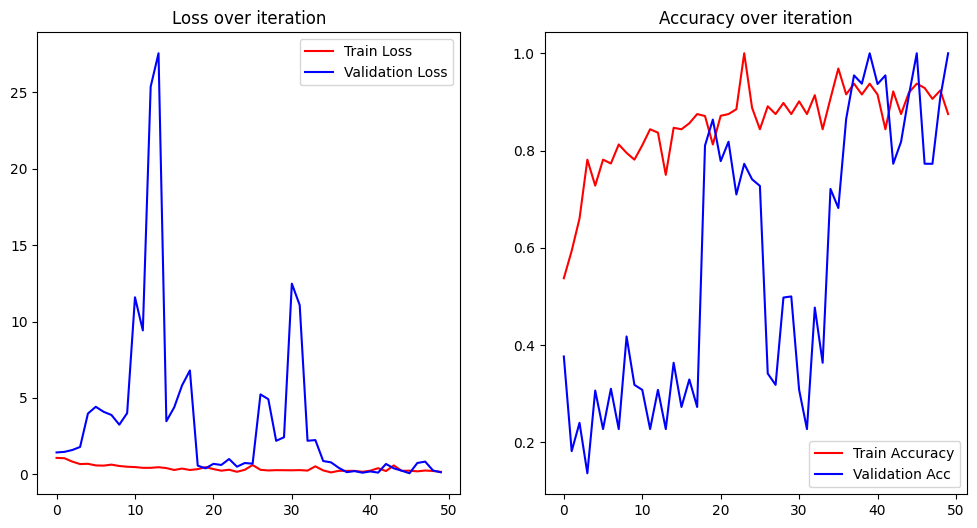

In [13]:
# Check the compatibility of model training
n = len(history.history['loss'])

fig = plt.figure(figsize = (12,6))

ax = fig.add_subplot(1,2,1)
ax.plot(range(n), (history.history['loss']), c = 'r', label = 'Train Loss')
ax.plot(range(n), (history.history['val_loss']), c = 'b', label = 'Validation Loss')
ax.legend()
ax.set_title('Loss over iteration')

ax = fig.add_subplot(1,2,2)
ax.plot(range(n), (history.history['accuracy']), c = 'r', label = 'Train Accuracy')
ax.plot(range(n), (history.history['val_accuracy']), c = 'b', label = 'Validation Acc')
ax.legend(loc = 'lower right')
ax.set_title('Accuracy over iteration')

### Model Evaluation:

In [14]:
# Evaluate Model
model.evaluate(test_gen)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.9124 - loss: 0.1799


[0.21519190073013306, 0.8873239159584045]

In [15]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.LANCZOS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.LANCZOS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.LANCZOS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    pred = model.predict(ar)
    
    # Get the index of the highest probability
    pred_class = np.argmax(pred, axis=-1)  # This returns the index of the highest probability

    # Map the predicted class to its label
    if pred_class == 0:
        prediction = 'Healthy (No Tumor)'
    elif pred_class == 1:
        prediction = 'Pituitary'
    elif pred_class == 2:
        prediction = 'Meningiona'
    else:
        prediction = 'Glioma'
        
    print(f"Type of tumor: {prediction}")
    return im.resize((300,300), Image.LANCZOS)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
Type of tumor: Healthy (No Tumor)


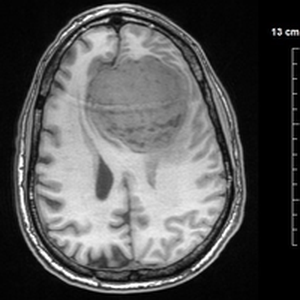

In [16]:
# Test 1
process_and_predict('/kaggle/input/test-image-brain-tumor/img1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Type of tumor: Healthy (No Tumor)


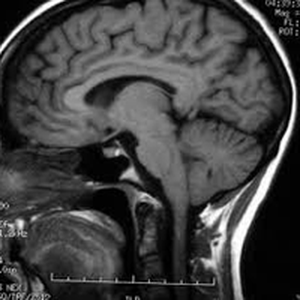

In [17]:
# Test 2
process_and_predict('/kaggle/input/test-image-brain-tumor/img2.jpg')

## Conclusion  
The CNN-based model developed in this project provides a reliable method for **automated brain tumor classification** using MRI scans. With an accuracy of **92%**, it has the potential to assist radiologists in diagnosing brain tumors more efficiently and reducing diagnostic errors. This technology can be integrated into **computer-aided diagnosis (CAD) systems** to support medical professionals in identifying and classifying tumors with greater precision.  

However, further improvements can be made by using **pretrained deep learning models** like VGG16, ResNet, or EfficientNet to enhance accuracy. Additionally, integrating larger and more diverse datasets could further improve the model's robustness.  

### **Future Scope**  
- **Deployment in healthcare systems** for real-time MRI analysis.  
- **Enhancing accuracy** using transfer learning or hybrid models.  
- **Using 3D MRI scans** for more precise classification.  
---